### **Importing Libraries**

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import seaborn as sns
import cv2
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D , Convolution2D
from keras.layers import MaxPooling2D,MaxPool2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import seaborn as sns
from sklearn import metrics
from io import BytesIO 
import seaborn as sns; sns.set()
import tensorflow
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from sklearn.metrics import cohen_kappa_score , matthews_corrcoef , classification_report , roc_auc_score , accuracy_score
from sklearn.ensemble import RandomForestClassifier

### **Sample image from COVID dataset**

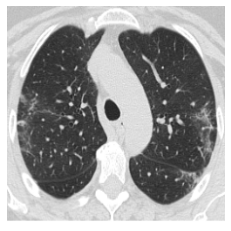

In [2]:
img = plt.imread("/content/drive/My Drive/dataset_pr/COVID/Covid (1).png")
img = cv2.resize(img,(224,224))
plt.imshow(img)
plt.axis("off")
plt.show()

### **Labelling images into two classes**

In [3]:
x_ = list()
y = list()
IMG_SIZE = 224
c = 0
nc = 0
for i in os.listdir("/content/drive/My Drive/dataset_pr/COVID"):
    try:
        path = "/content/drive/My Drive/dataset_pr/COVID/"+i
        #print('1')
        img = cv2.imread(path)
        img_ = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
        img_arr = np.asarray(img_)
        x_.append(img_arr)
        y.append(1)
        c = c+1
    except:
        None
for i in os.listdir("/content/drive/My Drive/dataset_pr/NON-COVID"):
    try:
        path = "/content/drive/My Drive/dataset_pr/NON-COVID/"+i
        img = cv2.imread(path)
        img_ = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
        img_arr = np.asarray(img_)
        x_.append(img_arr)
        y.append(0)
        nc = nc+1
    except:
        None

In [4]:
x1=[]
from keras.preprocessing import image
for item in x_:
      if len(item.shape) > 2 and item.shape[2] == 4:
            item = cv2.cvtColor(item, cv2.COLOR_BGRA2BGR)
      x1.append(item)
Y = []
for i in range(1252):
    Y.append(1)

for i in range(1229):
    Y.append(0)
X = np.asarray(x1)
y = np.asarray(Y)
from keras.utils.np_utils import to_categorical
y = to_categorical(y,num_classes = 2)

### **Train Test and Validation Split**

In [5]:
X_train,x_test,y_train,y_test = train_test_split(*shuffle(X, y),test_size = 0.15,random_state = 42)
X_train,x_val,y_train,y_val = train_test_split(*shuffle(X_train, y_train),test_size = 0.10,random_state = 42)

### **Function for Confusion Matrix**

In [6]:
def print_confusion_matrix():
    matrix = confusion_matrix(y_test.argmax(axis=1), max_y_pred_test.argmax(axis=1))
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,cmap='coolwarm',linecolor='white',linewidths=1,annot=True,fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

### **Function for Model accuarcy Loss**

In [7]:
def plot_model_accuracy_loss():
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
    plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
    plt.plot(history.history['loss'], 'r--', label='Loss of training data')
    plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
    plt.title('Model Accuracy and Loss')
    plt.ylabel('Accuracy and Loss')
    plt.xlabel('Training Epoch')
    plt.ylim(0)
    plt.legend()
    plt.show()

### **Function for Performance parameters**

In [8]:
def print_performance_metrics():
    print('Accuracy:', np.round(metrics.accuracy_score(y_test.argmax(axis=1), max_y_pred_test.argmax(axis=1)),4))
    print('Precision:', np.round(metrics.precision_score(y_test.argmax(axis=1), max_y_pred_test.argmax(axis=1),average='weighted'),4))
    print('Recall:', np.round(metrics.recall_score(y_test.argmax(axis=1), max_y_pred_test.argmax(axis=1),average='weighted'),4))
    print('F1 Score:', np.round(metrics.f1_score(y_test.argmax(axis=1), max_y_pred_test.argmax(axis=1),average='weighted'),4))
    print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test.argmax(axis=1), max_y_pred_test.argmax(axis=1)),4))
    print('Matthews Corrcoef:', np.round(metrics.matthews_corrcoef(y_test.argmax(axis=1), max_y_pred_test.argmax(axis=1)),4))
    print('ROC AUC:',np.round(roc_auc_score(y_test.argmax(axis=1),max_y_pred_test.argmax(axis=1)),4)) 
    print('\t\tClassification Report:\n', metrics.classification_report(y_test.argmax(axis=1), max_y_pred_test.argmax(axis=1)))

### **Making BaseModel of VGG-19 and addinig one CNN layer**

In [9]:
baseModel = VGG19(weights="imagenet", include_top=False,input_shape=(224, 224, 3))
headModel = baseModel.output

#Layer 1
headModel = Sequential()(headModel)
headModel = Convolution2D(128, (3, 3),input_shape=(224,224,3))(headModel)
headModel = Activation('relu')(headModel)
headModel = MaxPooling2D(pool_size = (2,2))(headModel)
headModel = BatchNormalization()(headModel)


# Flattenning
headModel = Flatten(name="flatten")(headModel)

headModel = Dense(128, activation="relu")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dense(8, activation="relu")(headModel)
predictions = Dense(2, activation='sigmoid')(headModel)

from keras.models import Model
model1 = Model(inputs=baseModel.input, outputs=predictions)


for layer in baseModel.layers:
	layer.trainable = False
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model1.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

history= model1.fit(X_train, y_train, epochs=20, verbose=1, validation_split=0.1)
print('CV accuracy:' , np.average(history.history['val_accuracy']))

80142336/80134624 [==============================] - 7s 0us/step
Train on 1707 samples, validate on 190 samples
Epoch 1/20
1707/1707 [==============================] - 32s 19ms/step - loss: 0.3675 - accuracy: 0.8333 - val_loss: 0.4311 - val_accuracy: 0.8737
Epoch 2/20
1707/1707 [==============================] - 20s 11ms/step - loss: 0.0937 - accuracy: 0.9681 - val_loss: 0.1095 - val_accuracy: 0.9526
Epoch 3/20
1707/1707 [==============================] - 20s 12ms/step - loss: 0.0380 - accuracy: 0.9856 - val_loss: 0.1592 - val_accuracy: 0.9421
Epoch 4/20
1707/1707 [==============================] - 20s 12ms/step - loss: 0.0339 - accuracy: 0.9877 - val_loss: 0.2449 - val_accuracy: 0.9211
Epoch 5/20
1707/1707 [==============================] - 20s 12ms/step - loss: 0.0167 - accuracy: 0.9950 - val_loss: 0.1239 - val_accuracy: 0.9474
Epoch 6/20
1707/1707 [==============================] - 20s 12ms/step - loss: 0.0040 - accuracy: 0.9988 - val_loss: 0.0931 - val_accuracy: 0.9737
Epoch 7/20
1

### **Model performance and results**

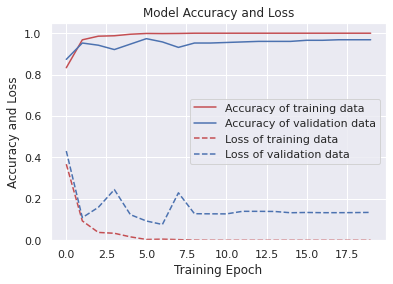

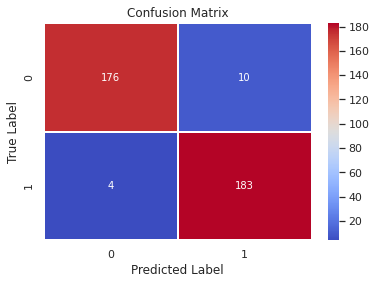

Accuracy: 0.9625
Precision: 0.9629
Recall: 0.9625
F1 Score: 0.9625
Cohen Kappa Score: 0.9249
Matthews Corrcoef: 0.9254
ROC AUC: 0.9624
		Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.96       186
           1       0.95      0.98      0.96       187

    accuracy                           0.96       373
   macro avg       0.96      0.96      0.96       373
weighted avg       0.96      0.96      0.96       373



In [10]:
y_pred_test = model1.predict(x_test)
max_y_pred_test = np.round(y_pred_test)
plot_model_accuracy_loss()
print_confusion_matrix()
print_performance_metrics()